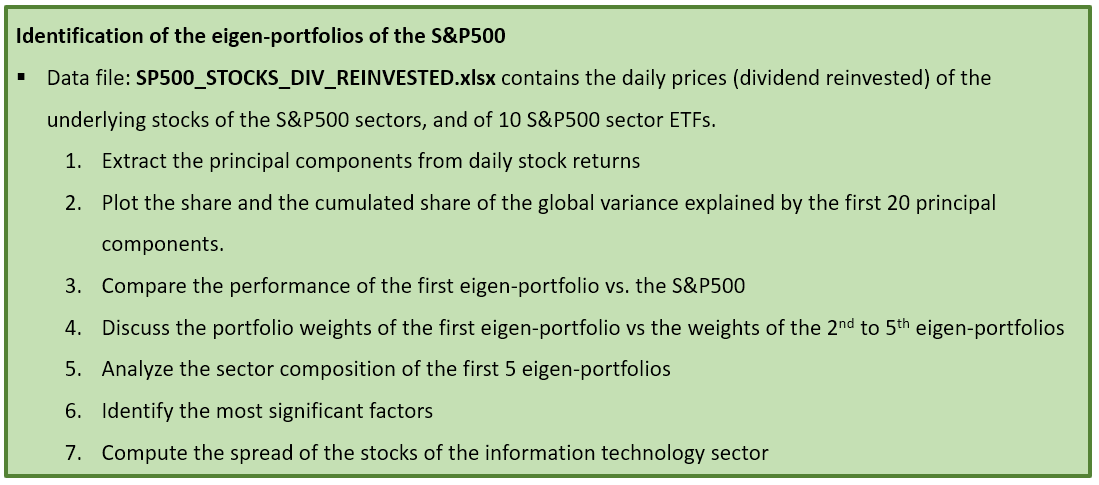

Import libraries

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn import preprocessing
from matplotlib import pyplot as plt
from statsmodels.multivariate.pca import PCA as PCA
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

Import data

In [2]:
for i in range(10):
    if i==0:
        ALL_STOCKS=pd.read_excel('SP500_STOCKS_DIV_REINVESTED.xlsx', i+2, usecols='B:ZZ')
        NAMES=list(ALL_STOCKS)
        ALL_STOCKS=np.array(ALL_STOCKS)
        SECTOR_ID=np.zeros((ALL_STOCKS.shape[1]))
    else:
        load=pd.read_excel('SP500_STOCKS_DIV_REINVESTED.xlsx', i+2, usecols='B:ZZ')
        NAMES=NAMES+list(load)
        ALL_STOCKS=np.append(ALL_STOCKS,np.array(load),axis=1)
        SECTOR_ID=np.append(SECTOR_ID,np.zeros((np.array(load).shape[1]))+i)
SP500=np.array(pd.read_excel('SP500_STOCKS_DIV_REINVESTED.xlsx', 'MarketIndex', usecols='B'))
SECTOR_LABELS=['Communication services', 'Consumer Discretionary', 'Consumer Staples', 'Energy', 'Financials', 'Healthcare', 'Industrials','Information Technology', 'Materials', 'Utilities' ]

Selecting stocks with no missing sata

In [3]:
select=(1-np.sum(np.isnan(ALL_STOCKS),axis=0)==1)
STOCKS_SELECT=ALL_STOCKS[:,select]
select_id=np.arange(0,ALL_STOCKS.shape[1],1)[select]
NAMES_SELECT=[NAMES[i] for i in select_id]
SECTOR_ID_SELECT=SECTOR_ID[select]
n_stocks=STOCKS_SELECT.shape[1]

Compute daily returns

In [4]:
RETURNS=STOCKS_SELECT[1:,:]/STOCKS_SELECT[:-1,:]-1
RETURNS_NORM=preprocessing.scale(RETURNS)
RETURNS_SP500=SP500[1:,:]/SP500[:-1,:]-1
n_obs=len(RETURNS)

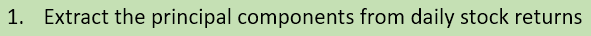

In [5]:
out_pca=PCA(RETURNS_NORM)

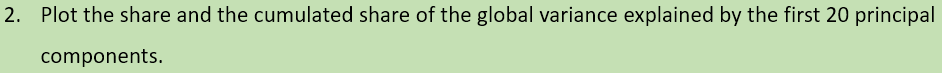

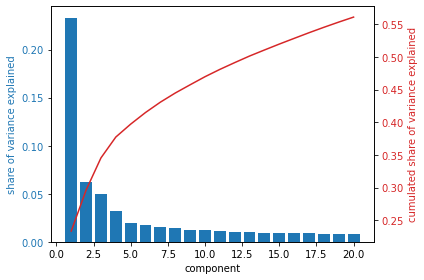

In [6]:
share_variance=out_pca.eigenvals[:20]/sum(out_pca.eigenvals)
share_variance_cumulated=np.cumsum(share_variance)

fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('component')
ax1.set_ylabel('share of variance explained', color=color)
ax1.bar(np.arange(1,21,1), share_variance, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('cumulated share of variance explained', color=color)
ax2.plot(np.arange(1,21,1), share_variance_cumulated, color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()
plt.rcParams['figure.figsize'] = [20, 5]
plt.show()

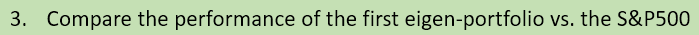

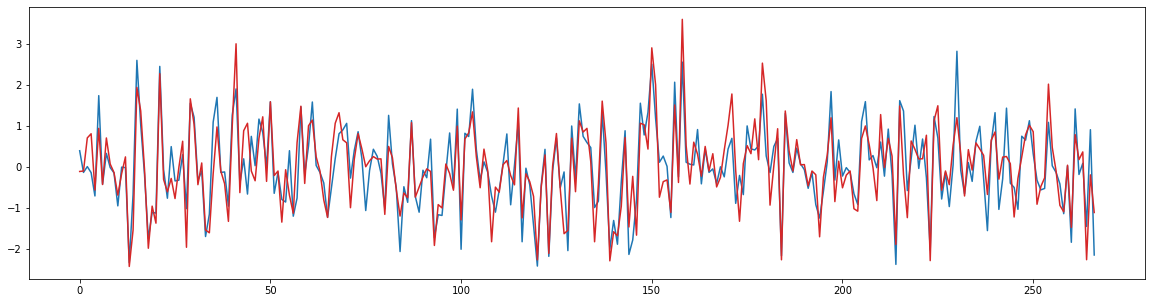

In [7]:
FACTORS=preprocessing.scale(out_pca.factors)
RETURNS_SP500_NORM=preprocessing.scale(RETURNS_SP500)
y1=plt.plot(RETURNS_SP500_NORM, color='tab:blue')
y2=plt.plot(FACTORS[:,0],color='tab:red')
plt.rcParams['figure.figsize'] = [20, 5]
plt.show()

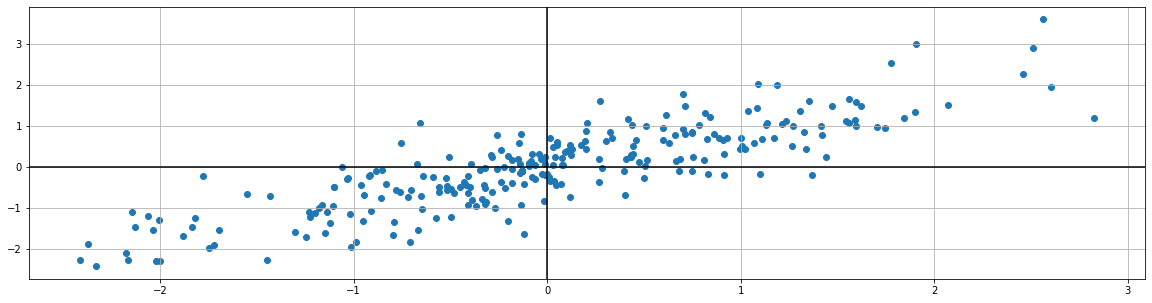

In [8]:
plt.scatter(RETURNS_SP500_NORM, FACTORS[:,0])
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.rcParams['figure.figsize'] = [10, 10]
plt.show()

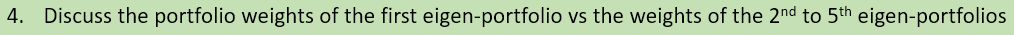

Weights of the first 5 eigen-portfolios

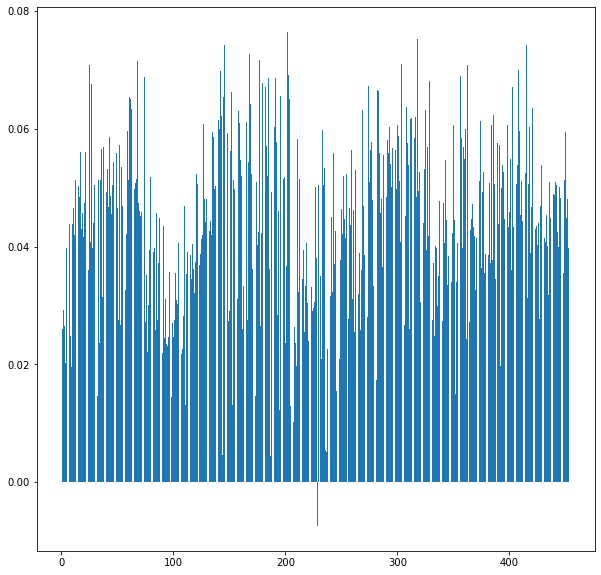

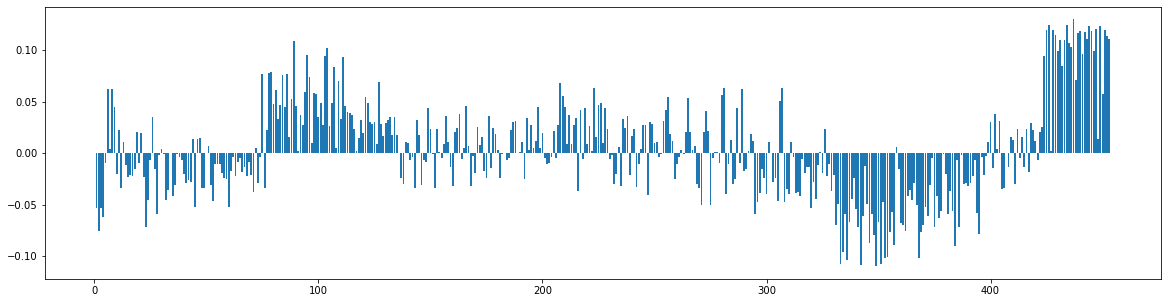

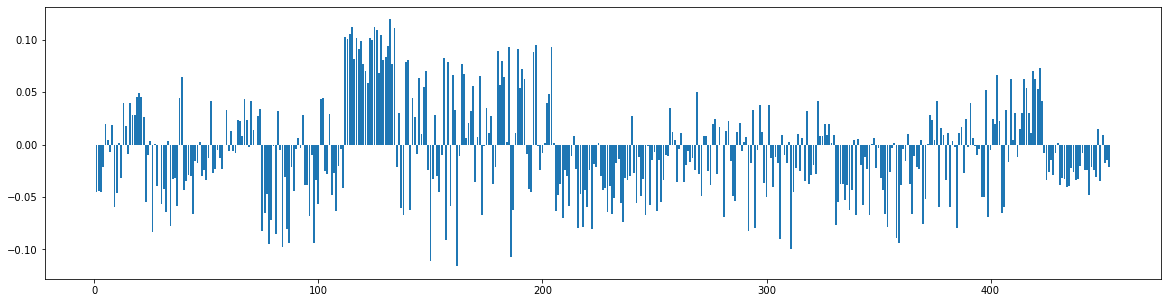

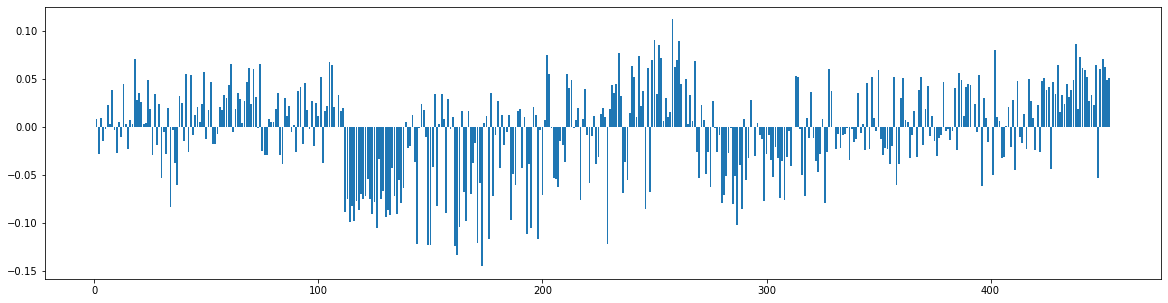

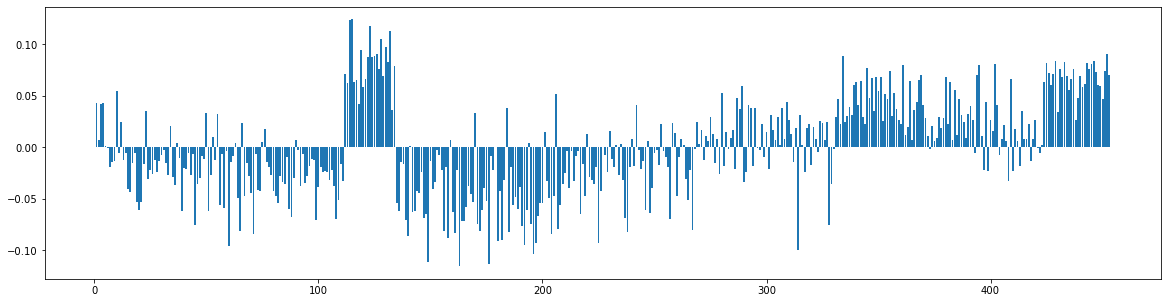

In [9]:
for i in range(5):
    plt.bar(np.arange(1,n_stocks+1,1), out_pca.eigenvecs[:,i])
    plt.rcParams['figure.figsize'] = [20, 5]
    plt.show()

Weight distribution of the first eigen-portfolio

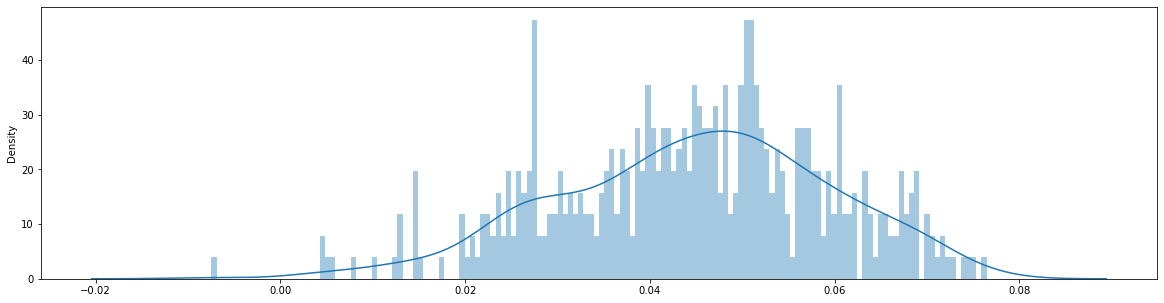

In [10]:
plt.rcParams['figure.figsize'] = [20, 5]
sns.distplot(out_pca.eigenvecs[:,0], hist=True, kde=True, bins=150)
plt.show()

Weight distribution of 2nd to 5th eigen-portfolios

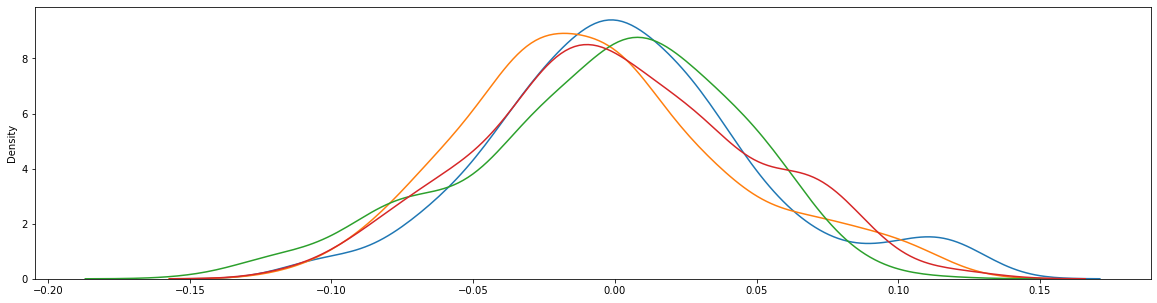

In [11]:
for i in range(4):
    plt.rcParams['figure.figsize'] = [20, 5]
    sns.distplot(out_pca.eigenvecs[:,i+1], hist=False, kde=True, bins=150)

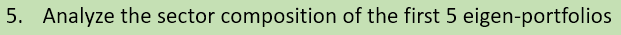

Gross sector exposure of the first 5 eigen-portfolios

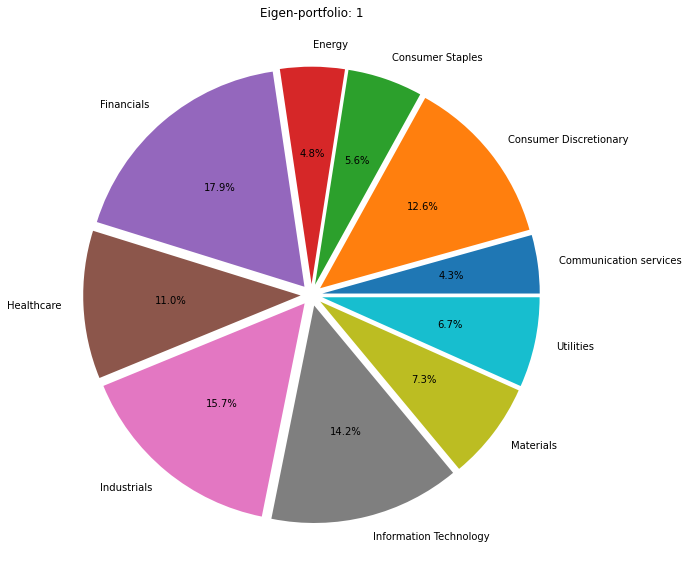

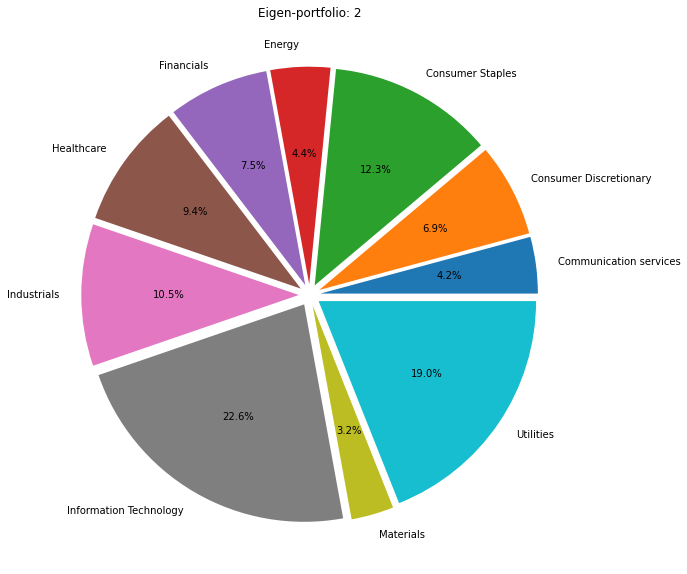

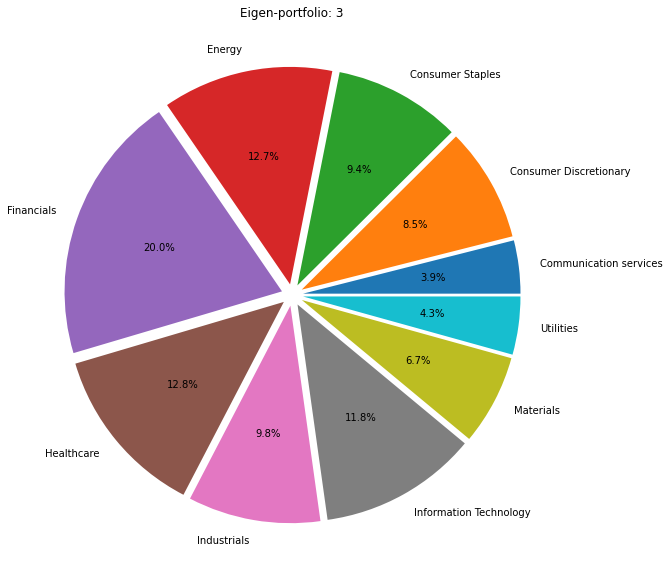

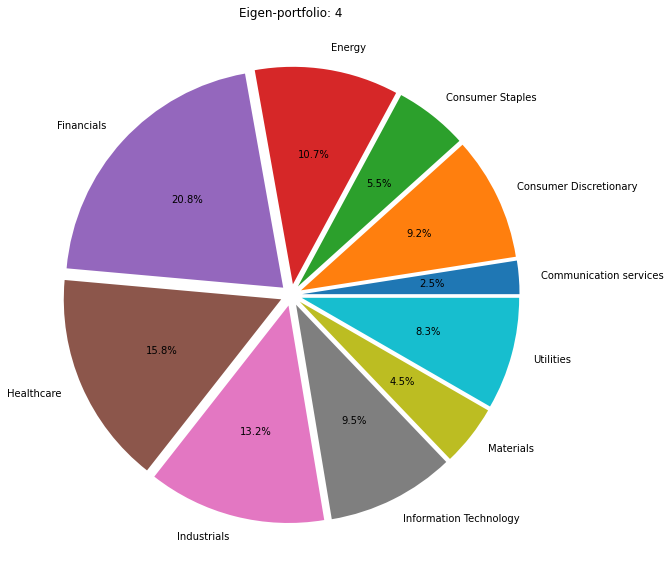

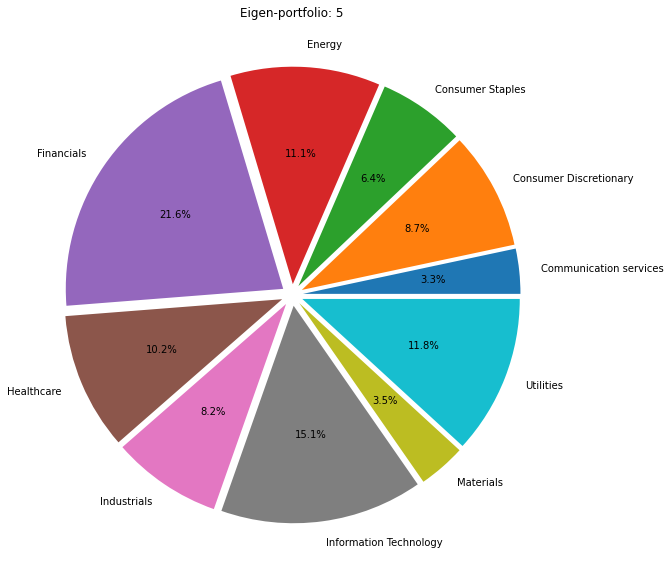

In [12]:
plt.rcParams['figure.figsize'] = [10, 10]
table_sector_weights=np.zeros((10,5))
for i in range(5):
    weights=out_pca.eigenvecs[:,i]
    for j in range(10):
        table_sector_weights[j,i]=sum(abs(weights[SECTOR_ID_SELECT==j]))/sum(abs(weights))

for i in range(5):
    plt.figure()
    plt.title('Eigen-portfolio: %i' %(i+1))
    plt.pie(table_sector_weights[:,i],labels=SECTOR_LABELS, autopct='%1.1f%%',explode=np.ones((10))*0.05)
    a=plt.plot()

Net sector allocation of the first 5 eigen-portfolios

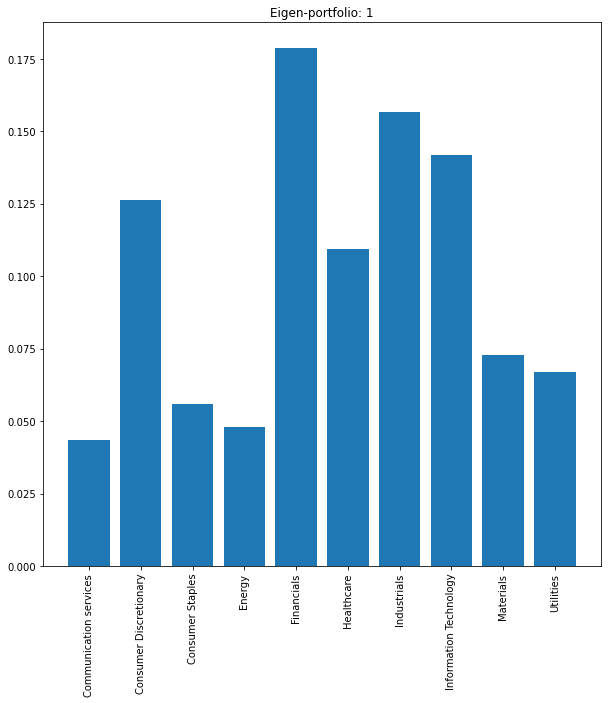

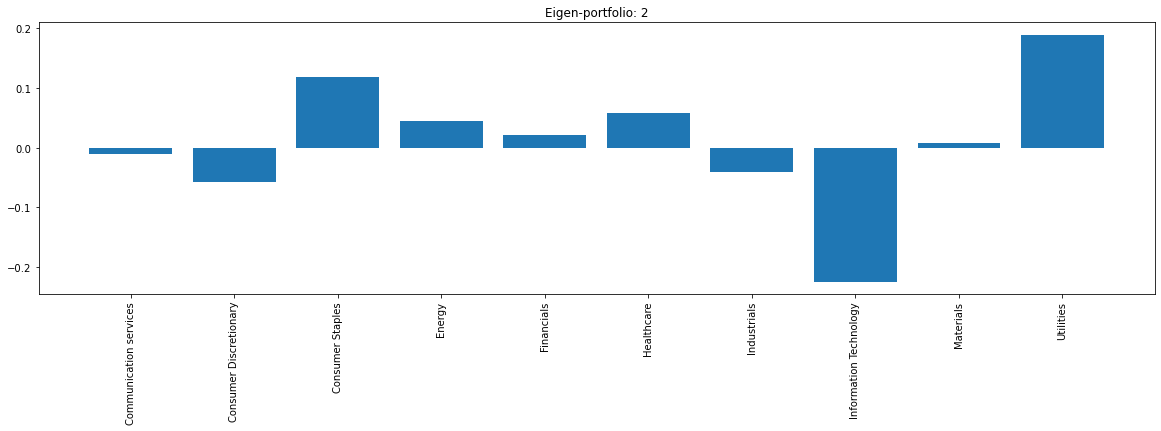

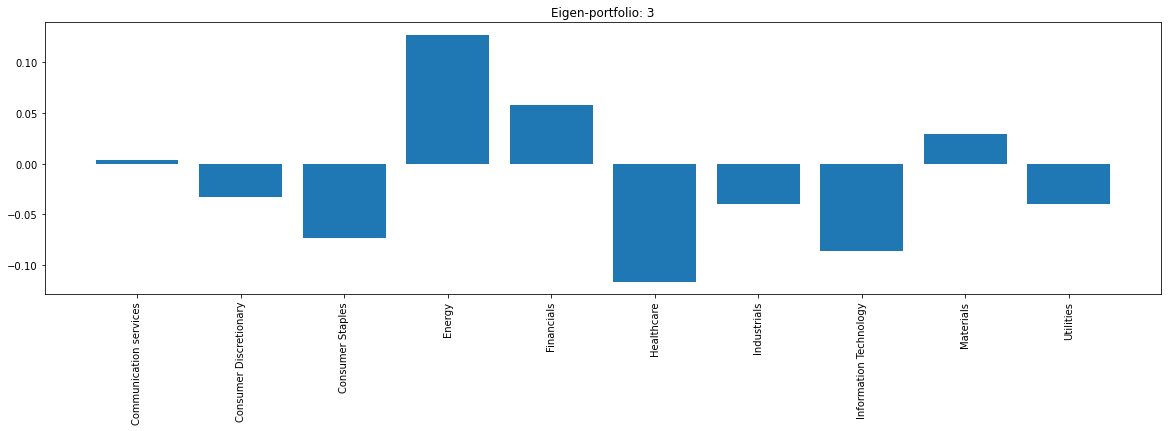

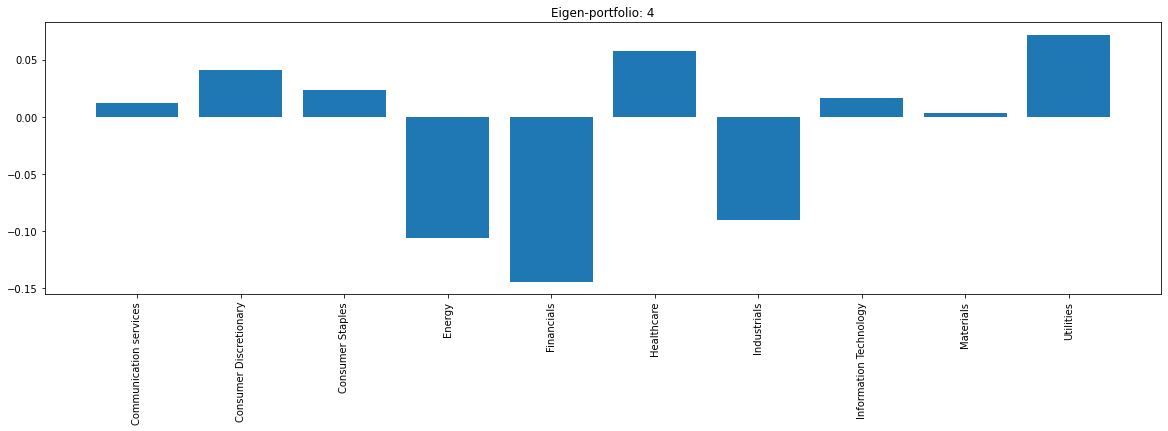

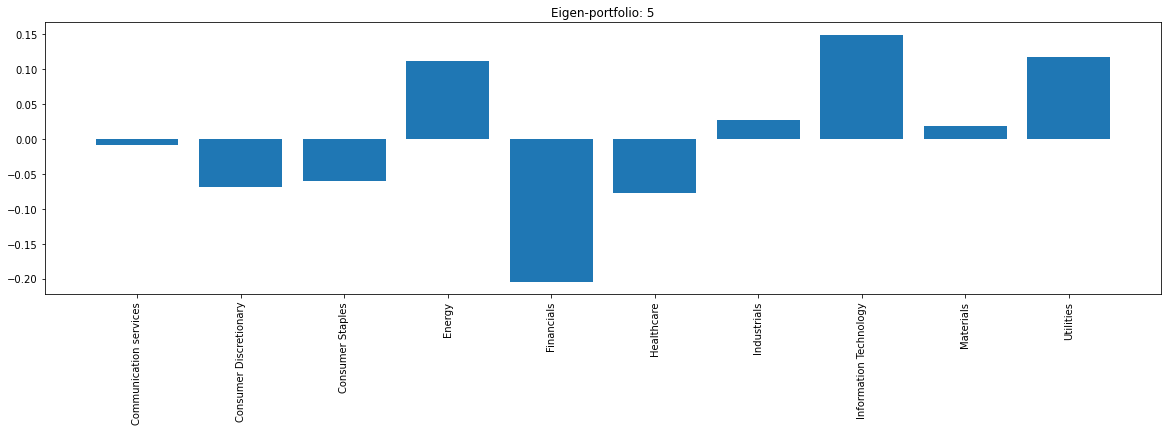

In [13]:
table_sector_weights2=np.zeros((10,5))
for i in range(5):
    weights=out_pca.eigenvecs[:,i]
    for j in range(10):
        table_sector_weights2[j,i]=sum(weights[SECTOR_ID_SELECT==j])/sum(abs(weights))

for i in range(5):
    plt.figure()
    plt.rcParams['figure.figsize'] = [20, 5]
    plt.title('Eigen-portfolio: %i' %(i+1))
    plt.tick_params(axis='x', labelrotation=90)
    plt.bar(SECTOR_LABELS,table_sector_weights2[:,i])
    plt.plot()

Sectors of the 20 largest positions (in absolute value)

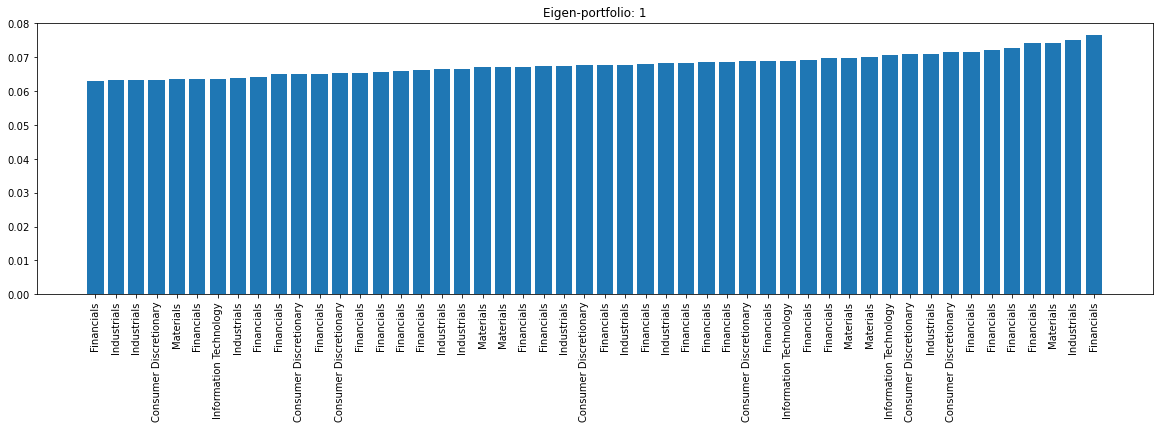

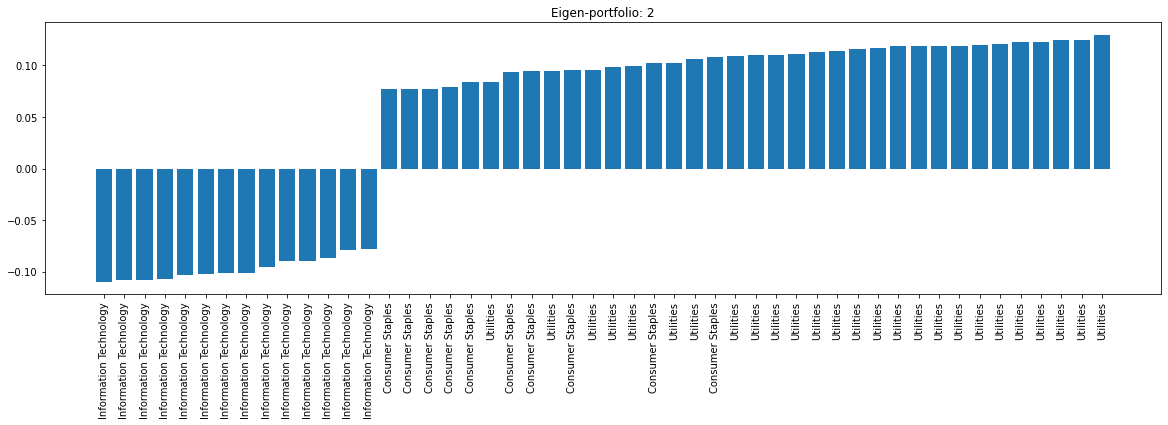

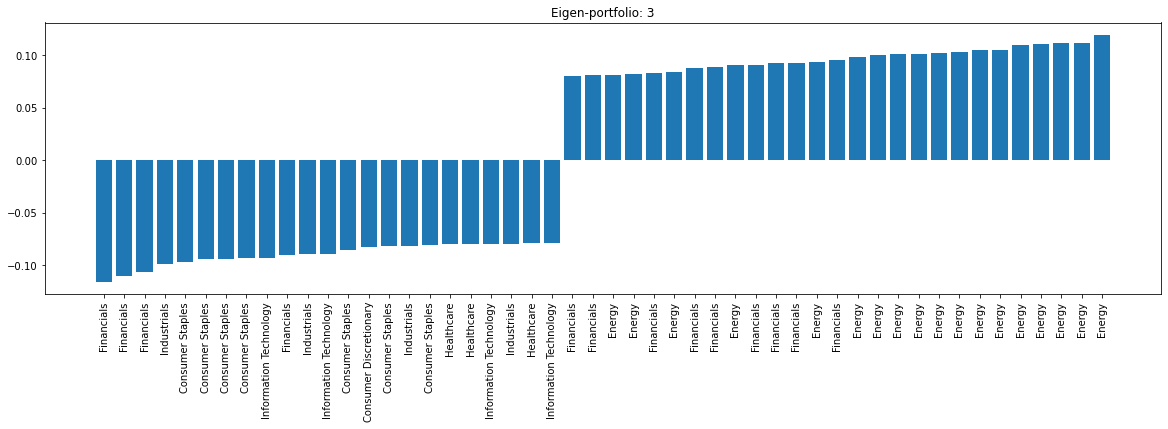

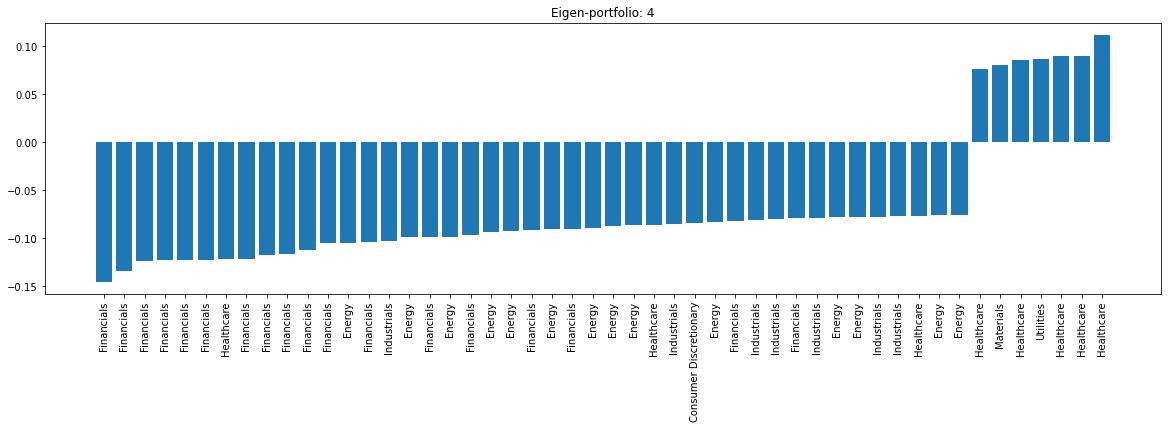

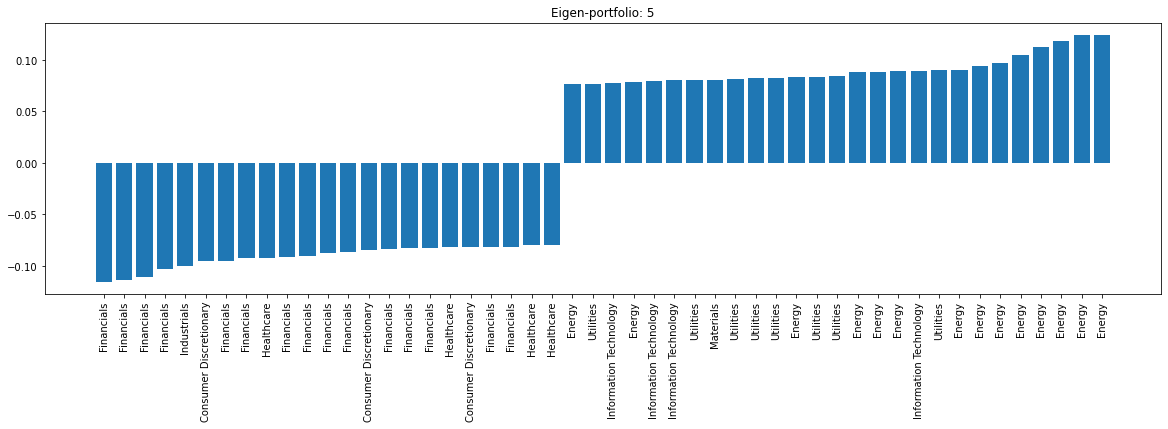

In [14]:
n=50
for i in range(5):
    data=np.zeros((n_stocks,2))
    data[:,0]=out_pca.eigenvecs[:,i]
    data[:,1]=SECTOR_ID_SELECT
    data_sort=data[(-abs(data[:, 0])).argsort()]
    data_sort=data_sort[data_sort[:n, 0].argsort()]
    labels=[SECTOR_LABELS[int(data_sort[i,1])] for i in range(n)]
    plt.rcParams['figure.figsize'] = [20, 5]
    plt.figure()
    plt.title('Eigen-portfolio: %i' %(i+1))
    plt.tick_params(axis='x', labelrotation=90)
    plt.bar(np.arange(0,n,1),data_sort[:n,0], tick_label=labels)
    plt.plot()

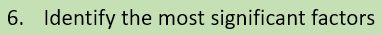

6.1. Rescaled eigenvalues > 1

Number of factors with rescaled eigenvalues > 1: 57


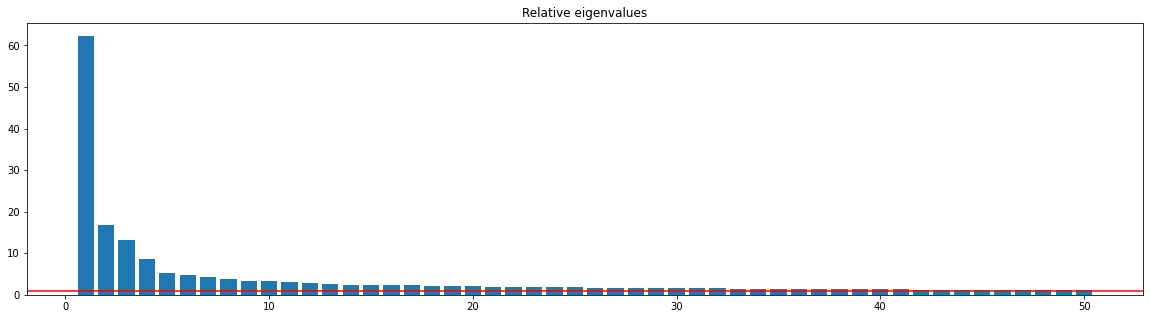

In [15]:
rescaled_eig=out_pca.eigenvals/np.mean(out_pca.eigenvals)
print('Number of factors with rescaled eigenvalues > 1: %i' %(sum(rescaled_eig>1)))
plt.bar(np.arange(1,51,1),rescaled_eig[:50])
plt.axhline(y=1, xmin=0, xmax=20,color='red')
plt.title('Relative eigenvalues')
plt.show()

6.2. Elbow method

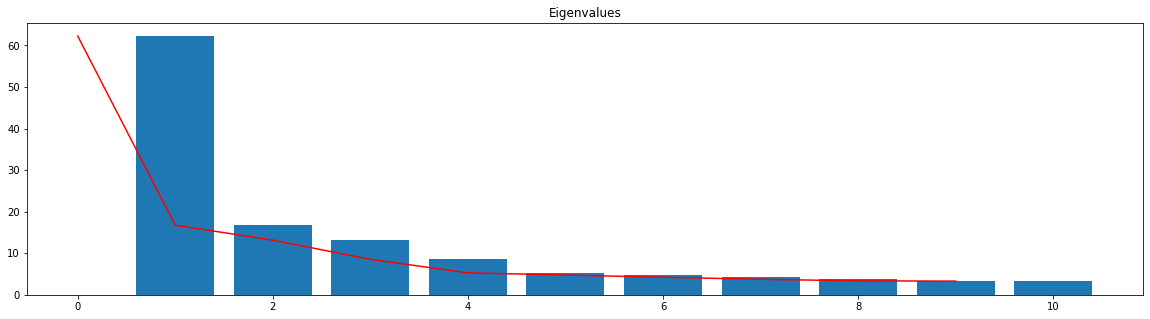

In [16]:
plt.bar(np.arange(1,11,1),rescaled_eig[:10])
plt.plot(rescaled_eig[:10], color='red')
plt.title('Eigenvalues')
plt.show()

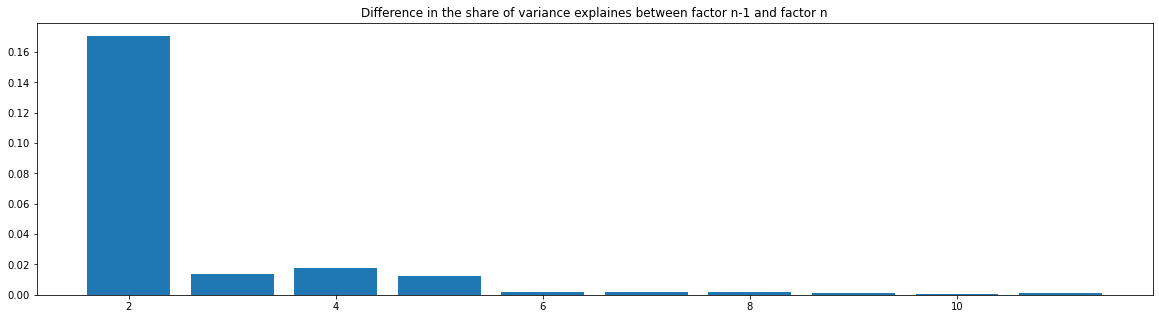

In [17]:
d_share=share_variance[1:]-share_variance[:-1]
plt.bar(np.arange(2,12,1),-d_share[:10])
plt.title('Difference in the share of variance explaines between factor n-1 and factor n')
plt.show()

6.3. Bai and Ng criteria

In [18]:
N_FACTORS=min((out_pca.ic[:50,:]).argmin(axis=0))+1
print('%i factors retreiving ' %(N_FACTORS)+ '%i percent of the global variance' %(share_variance_cumulated[N_FACTORS-1]*100))

5 factors retreiving 39 percent of the global variance


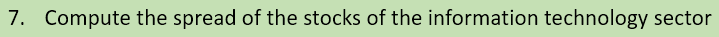

Select Info Tech stocks

In [19]:
IT_RETURNS=RETURNS[:,SECTOR_ID_SELECT==7]

In [20]:
n_IT_stocks=IT_RETURNS.shape[1]
SPREADS_OLS=np.zeros((n_obs,n_IT_stocks))
id_IT=np.arange(0,n_stocks,1)[SECTOR_ID_SELECT==7]
NAMES_IT=[NAMES_SELECT[i] for i in id_IT]
for i in range(n_IT_stocks):
    model=sm.OLS(IT_RETURNS[:,i],sm.add_constant(FACTORS[:,:N_FACTORS]))
    output=model.fit()
    betas_ols=output.params[1:]
    SPREADS_OLS[:,i]=np.cumsum(output.resid)

Plot NVIDIA spread

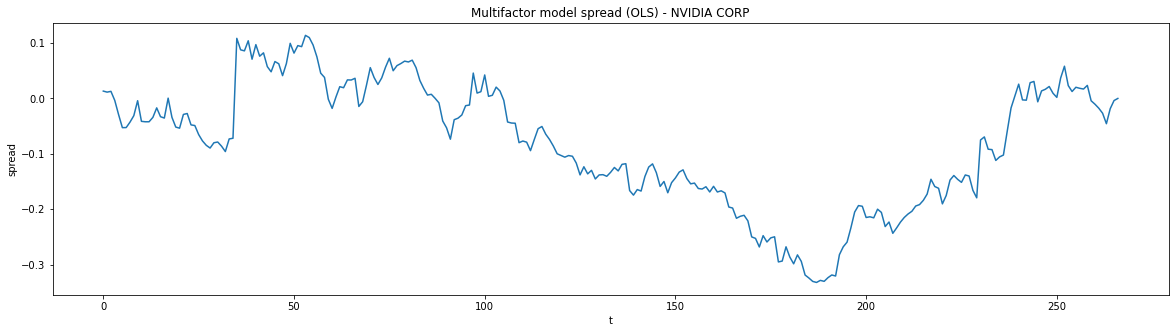

In [21]:
stock=2
plt.plot(SPREADS_OLS[:,stock])
plt.xlabel("t")
plt.ylabel("spread")
plt.title("Multifactor model spread (OLS) - "+NAMES_IT[stock])
plt.show()